<a href="https://colab.research.google.com/github/HarshZ26/Object-Detection/blob/master/Raccoon_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls
! git clone "https://github.com/datitran/raccoon_dataset.git"

sample_data
Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 652, done.
remote: Total 652 (delta 0), reused 0 (delta 0), pack-reused 652
Receiving objects: 100% (652/652), 48.01 MiB | 35.47 MiB/s, done.
Resolving deltas: 100% (415/415), done.


In [ ]:
%matplotlib inline
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import csv
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torchvision
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from random import randrange
import torch.nn as nn
import torch.nn.functional as F
import imutils
import cv2


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    image_path = '/content/raccoon_dataset/annotations'
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('raccoon_labels.csv', index=None)
    print(xml_df)
    print('Successfully converted xml to csv.')


main()

            filename  width  height    class  xmin  ymin  xmax  ymax
0     raccoon-30.jpg    266     190  raccoon    78    25   182   177
1    raccoon-122.jpg    178     283  raccoon     7     7   174   198
2     raccoon-80.jpg    225     225  raccoon    21    27   177   182
3    raccoon-186.jpg    640     428  raccoon    34    40   536   387
4      raccoon-4.jpg    275     183  raccoon    21    11   200   183
..               ...    ...     ...      ...   ...   ...   ...   ...
212  raccoon-195.jpg    225     225  raccoon    25   111   197   225
213   raccoon-75.jpg    640     640  raccoon     1     1   640   459
214  raccoon-145.jpg    600     450  raccoon     3    36   345   450
215  raccoon-145.jpg    600     450  raccoon   260    41   569   449
216  raccoon-197.jpg   1280     720  raccoon   114    35   987   653

[217 rows x 8 columns]
Successfully converted xml to csv.


In [ ]:
# opening the CSV file
with open('/content/raccoon_labels.csv', mode ='r')as file:
   
  # reading the CSV file
  csvFile = csv.reader(file)
 
  # displaying the contents of the CSV file
  for lines in csvFile:
    print(lines)

['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
['raccoon-30.jpg', '266', '190', 'raccoon', '78', '25', '182', '177']
['raccoon-122.jpg', '178', '283', 'raccoon', '7', '7', '174', '198']
['raccoon-80.jpg', '225', '225', 'raccoon', '21', '27', '177', '182']
['raccoon-186.jpg', '640', '428', 'raccoon', '34', '40', '536', '387']
['raccoon-4.jpg', '275', '183', 'raccoon', '21', '11', '200', '183']
['raccoon-22.jpg', '640', '360', 'raccoon', '252', '76', '466', '335']
['raccoon-155.jpg', '259', '194', 'raccoon', '46', '91', '143', '169']
['raccoon-193.jpg', '634', '852', 'raccoon', '23', '215', '440', '831']
['raccoon-110.jpg', '184', '274', 'raccoon', '23', '2', '166', '262']
['raccoon-91.jpg', '236', '314', 'raccoon', '22', '14', '216', '308']
['raccoon-98.jpg', '480', '360', 'raccoon', '108', '31', '351', '308']
['raccoon-43.jpg', '480', '360', 'raccoon', '1', '65', '239', '316']
['raccoon-123.jpg', '640', '406', 'raccoon', '280', '42', '550', '392']
['raccoon-59

In [ ]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root_img, root_label, transforms=None,id = None):
        self.root_img = root_img
        self.root_label = root_label
        # the list of filename
        self.transforms = transforms
        self.file = open(root_label)
        self.reader = csv.reader(self.file)
        temp_lis1 = list(self.reader)
        self.lis = temp_lis1[1:] + temp_lis1[1:90]
        self.id = id
        # the list of label

    def __getitem__(self, index):
        # obtain filenames from list
        image_filename = self.lis[index][0]
        # Load data and label
        image = Image.open(os.path.join(self.root_img, image_filename),'r')
        # print(type(image))
        width,height,cls,xmin,ymin,xmax,ymax = self.lis[index][1:]
        if self.id==1:
          if index >170:
            cls=0
            im1 = image.crop((0,0,64,64))
          else:
            cls = 1
            im1 = image.crop((int(xmin),int(ymin), int(xmax), int(ymax)))
        if self.id==0:
          if index >44:
            cls=0
            im1 = image.crop((0,0,64,64))
          else:
            cls = 1
            im1 = image.crop((int(xmin),int(ymin), int(xmax), int(ymax)))
        temp_var1 ,temp_var2 = image.size
        im1 = im1.resize((256, 256))
        mulx = 256/temp_var1
        muly = 256/temp_var2
        box = [[round(int(xmin)*mulx),round(int(ymin)*muly), round(int(xmax)*mulx), round(int(ymax)*muly)]]
        # Bounding boxes for objects
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        cls = torch.tensor(int(cls), dtype=torch.int64)
        box = torch.tensor(box).squeeze()
        # Size of bbox (Rectangular)
        if self.transforms is not None:
            image = self.transforms(im1)
        return image,cls,box

    def __len__(self):
        return len(self.lis)

In [ ]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [ ]:
# to remove grayscale images from directory and updating the labels
path_img = '/content/raccoon_dataset/images'
path_label = '/content/raccoon_dataset/data/train_labels.csv'
df = pd.read_csv("/content/raccoon_dataset/data/train_labels.csv")
  
# updating the column value/data
print(df.loc[df['filename']=='raccoon-161.jpg'])
print(df.loc[df['filename']=='raccoon-150.jpg'])
print(df.loc[df['filename']=='raccoon-152.jpg'])

df.drop(index = 124,inplace = True)
df.drop(index = 135,inplace = True)
df.drop(index = 172,inplace = True)

df.to_csv("AllDetails.csv", index=False)
# writing into the file

            filename  width  height    class  xmin  ymin  xmax  ymax
124  raccoon-161.jpg    500     347  raccoon   209    73   385   186
            filename  width  height    class  xmin  ymin  xmax  ymax
135  raccoon-150.jpg    275     183  raccoon    80    62   187   169
            filename  width  height    class  xmin  ymin  xmax  ymax
172  raccoon-152.jpg    275     183  raccoon    41    60   223   155


In [ ]:
# path to your own data and csv file
train_data_dir = '/content/raccoon_dataset/images'
train_label = '/content/AllDetails.csv'
test_data_dir = '/content/raccoon_dataset/images'
test_label = '/content/raccoon_dataset/data/test_labels.csv'
batchsize = 32


# create own Dataset
train_dataset = myOwnDataset(root_img = train_data_dir,root_label = train_label ,
                          transforms = get_transform(),id = 1
                          )
test_dataset = myOwnDataset(root_img = test_data_dir,root_label = test_label ,
                          transforms = get_transform(),id = 0
                          )

def collate_fn(batch):
  data = [item[0] for item in batch]
  target = [item[1] for item in batch]
  box = [item[2] for item in batch]
  target = torch.LongTensor(target)
  box = torch.stack(box,dim=0)
  data = torch.stack(data,dim=0)
  return [data, target,box]
# own DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batchsize,
                                          shuffle=True,
                                           collate_fn = collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batchsize,
                                          shuffle=True,
                                           collate_fn = collate_fn)

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: 32
box torch.Size([32, 4])


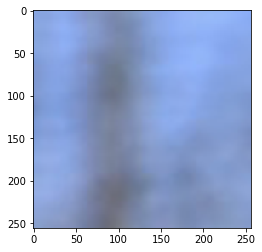

In [ ]:
train_features, train_labels,train_box= next(iter(test_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
print('box',train_box.size())
img = train_features[0].squeeze()
img1 = train_features[0].squeeze()
img = torchvision.transforms.functional.convert_image_dtype(image= img,dtype=torch.uint8)
img = img.numpy()
im2display = img.transpose((1,2,0))
plt.imshow(im2display, interpolation='nearest')

# def imshow(img):

#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# #Get some random training images
# dataiter = iter(train_loader)
# images, labels,box = dataiter.next()

# #Show images
# imshow(torchvision.utils.make_grid(images))

In [ ]:
num_epochs = 20
num_classes = 2
batch_size = 32
learning_rate = 0.001

class ConvNet(nn.Module):
  def __init__ (self):
    super(ConvNet,self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3,32, kernel_size =11, stride=1, padding =2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size =4,stride = 2),
        nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2))
    
    self.classifier = nn.Sequential(
        nn.Conv2d(256,128, kernel_size=15, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(128,64,kernel_size = 1,stride = 1,padding = 0),
        nn.ReLU(),
        nn.Conv2d(64,num_classes,kernel_size = 1,stride = 1,padding = 0)
        )
    self.regressor = nn.Sequential(
        nn.Conv2d(256,128, kernel_size=15, stride=1, padding=0, bias=False),
        nn.ReLU(),
        nn.Conv2d(128,64,kernel_size = 1,stride = 1,padding = 0, bias=False),
        nn.ReLU(),
        nn.Conv2d(64,4,kernel_size = 1,stride = 1,padding = 0,bias=False)
        )


  def forward(self,x):
    out = self.features(x)
    out1 = self.classifier(out)
    out2 = self.regressor(out)
    return out1,out2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet().to(device)
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
model.train()

ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Conv2d(256, 128, kernel_size=(15, 15), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (regress

In [ ]:
#train featurizer and classifier
total_step = len(train_loader)
correct_epoch = []
loss_lis1 = []
acc_lis = []


for epoch in range(num_epochs):
  num_correct = 0
  num_total = 0
  for i,(images,labels,box) in enumerate(train_loader):
    images, labels,box = images.to(device), labels.to(device), box.to(device)
    #Run the forward pass
    outputs,_= model(images)
    outputs = outputs.reshape(outputs.size(0),-1)
    
    #print("labels",labels)
    #print(outputs.size(),labels)
    loss = criterion1(outputs,labels)
    loss_lis1.append(loss.item())

    #Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #track accuracy
    total = labels.size(0)
    _ , predicted = torch.max(outputs.data,1)
    correct = (predicted ==labels).sum().item()
    acc_lis.append(correct/total)
    num_correct += correct
    num_total += total

    if (i+1)%4 == 0:
      print('Epoch [{}/{}],Step [{}/{}], Loss {: .4f}, Accuracy: {:.2f}%'
      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
      
  correct_epoch.append((num_correct/num_total)*100)

Epoch [1/20],Step [4/9], Loss  0.7118, Accuracy: 56.25%
Epoch [1/20],Step [8/9], Loss  0.6630, Accuracy: 68.75%
Epoch [2/20],Step [4/9], Loss  0.6518, Accuracy: 65.62%
Epoch [2/20],Step [8/9], Loss  0.9500, Accuracy: 56.25%
Epoch [3/20],Step [4/9], Loss  0.6273, Accuracy: 75.00%
Epoch [3/20],Step [8/9], Loss  0.6317, Accuracy: 68.75%
Epoch [4/20],Step [4/9], Loss  0.5479, Accuracy: 84.38%
Epoch [4/20],Step [8/9], Loss  0.6756, Accuracy: 62.50%
Epoch [5/20],Step [4/9], Loss  0.5715, Accuracy: 71.88%
Epoch [5/20],Step [8/9], Loss  0.6152, Accuracy: 68.75%
Epoch [6/20],Step [4/9], Loss  0.5727, Accuracy: 75.00%
Epoch [6/20],Step [8/9], Loss  0.7058, Accuracy: 25.00%
Epoch [7/20],Step [4/9], Loss  0.7516, Accuracy: 50.00%
Epoch [7/20],Step [8/9], Loss  0.6102, Accuracy: 68.75%
Epoch [8/20],Step [4/9], Loss  0.6213, Accuracy: 65.62%
Epoch [8/20],Step [8/9], Loss  0.5447, Accuracy: 78.12%
Epoch [9/20],Step [4/9], Loss  0.6158, Accuracy: 65.62%
Epoch [9/20],Step [8/9], Loss  0.5644, Accuracy:

tensor([ 2.3578, -2.5047], device='cuda:0')
tensor([-8.8943,  1.9905], device='cuda:0')
tensor([-4.5340,  1.0564], device='cuda:0')
Test Accuracy of the model test images: 79.54545454545455 %
correct: 70	total:88
[66.02316602316603, 66.02316602316603, 66.02316602316603, 72.97297297297297, 72.2007722007722, 59.07335907335908, 66.79536679536679, 66.79536679536679, 67.18146718146718, 68.33976833976834, 83.78378378378379, 87.64478764478764, 84.55598455598455, 87.64478764478764, 92.66409266409266, 87.25868725868726, 91.8918918918919, 94.20849420849422, 94.20849420849422, 93.05019305019306]


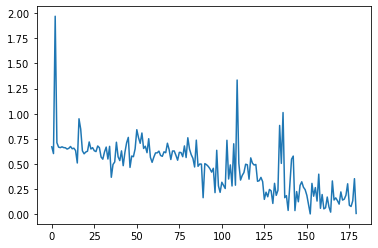

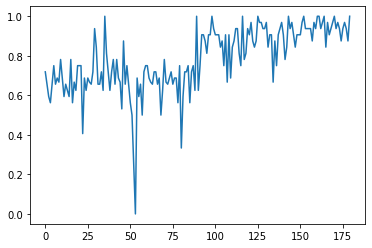

In [ ]:
# testing the trained classifier
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels,_ in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs,_ = model(images)
      outputs = outputs.reshape(outputs.size(0),-1)
      print(outputs[0])
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model test images: {} %'.format((correct / total) * 100))
    print('correct: '+str(correct)+'\t'+ 'total:'+str(total))

print(correct_epoch)
plt.plot(loss_lis1)
plt.show()
plt.plot(acc_lis)
plt.show()

In [ ]:
# another dataset to train regressor
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root_img, root_label, transforms=None):
        self.root_img = root_img
        self.root_label = root_label
        # the list of filename
        self.transforms = transforms
        self.file = open(root_label)
        self.reader = csv.reader(self.file)
        temp_lis1 = list(self.reader)
        self.lis = temp_lis1[1:]
        # the list of label

    def __getitem__(self, index):
        # obtain filenames from list
        image_filename = self.lis[index][0]
        # Load data and label
        image = Image.open(os.path.join(self.root_img, image_filename),'r')
        # print(type(image))
        width,height,cls,xmin,ymin,xmax,ymax = self.lis[index][1:]
        cls = 1
        temp_var1 ,temp_var2 = image.size
        im1 = image.resize((256, 256))
        mulx = 256/temp_var1
        muly = 256/temp_var2
        box = [[round(int(xmin)*mulx),round(int(ymin)*muly), round(int(xmax)*mulx), round(int(ymax)*muly)]]
        box = torch.tensor(box).squeeze()
        # Bounding boxes for objects
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        cls = torch.tensor(int(cls), dtype=torch.int64)

        if self.transforms is not None:
            image = self.transforms(im1)
        return image,cls,box

    def __len__(self):
        return len(self.lis)

In [ ]:
valid_data_dir = '/content/raccoon_dataset/images'
valid_label = '/content/AllDetails.csv'
batchsize = 32

# create own Dataset
valid_dataset = myOwnDataset(root_img = valid_data_dir,root_label = valid_label,
                          transforms = get_transform()
                          )

def collate_fn(batch):
  data = [item[0] for item in batch]
  target = [item[1] for item in batch]
  box = [item[2] for item in batch]
  target = torch.LongTensor(target)
  box = torch.stack(box,dim=0)
  data = torch.stack(data,dim=0)
  return [data, target,box]
# own DataLoader

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batchsize,
                                          shuffle=True,
                                           collate_fn = collate_fn)

Feature batch shape: torch.Size([32, 3, 256, 256])
box tensor([  6,   9, 248, 198])
torch.Size([32, 3, 256, 256])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


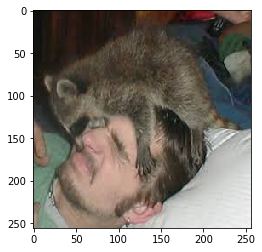

In [ ]:
valid_features, valid_labels,bbox= next(iter(valid_loader))
print(f"Feature batch shape: {valid_features.size()}")
print('box',bbox[0])
# print(f"Labels batch shape: {len(train_labels)}")
img = valid_features[0].squeeze()
img2 = valid_features
print(img2.size())
img1 = valid_features
# img1 = torchvision.transforms.functional.convert_image_dtype(image= img2,dtype=torch.uint8)
img1 = img1.numpy()
img = torchvision.transforms.functional.convert_image_dtype(image= img,dtype=torch.uint8)
img = img.numpy()
im2display = img.transpose((1,2,0))
plt.imshow(im2display, interpolation='nearest')
print(valid_labels)


In [ ]:
# freezing featurizer and classifier parameters 
learning_rate = 0.005
params = model.state_dict()
key = list(params.keys())
model.features[0].weight.requires_grad = False
model.features[0].bias.requires_grad = False
model.features[3].weight.requires_grad = False
model.features[3].bias.requires_grad = False
model.features[6].weight.requires_grad = False
model.features[6].bias.requires_grad = False
model.features[9].weight.requires_grad = False
model.features[9].bias.requires_grad = False
model.classifier[0].weight.requires_grad = False
model.classifier[0].bias.requires_grad = False
model.classifier[2].weight.requires_grad = False
model.classifier[2].bias.requires_grad = False
model.classifier[4].weight.requires_grad = False
model.classifier[4].bias.requires_grad = False
# model.features.requires_grad = True
# model.classifier.requires_grad = True

for name, param in model.named_parameters():
  if param.requires_grad:print(name)
  
optimizer2 = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = learning_rate)
model.train()

regressor.0.weight
regressor.2.weight
regressor.4.weight


ConvNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Conv2d(256, 128, kernel_size=(15, 15), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (regress

In [ ]:
#train regressor
total_step = len(valid_loader)
num_epochs = 100
correct_epoch = []
loss_lis2 = []

for epoch in range(num_epochs):
  num_correct = 0
  num_total = 0
  for i,(images,_,box) in enumerate(valid_loader):
    images,box = images.to(device),box.to(device,dtype=torch.float32)
    #Run the forward pass
    _,outputs= model(images)
    outputs = outputs.reshape(outputs.size(0),-1)    

    #print("labels",labels)
    #print(outputs.size(),labels)
    loss = criterion2(outputs,box)
    loss_lis2.append(loss.item())

    #Backprop
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()

    if (i+1)%4 == 0:
      print('Epoch [{}/{}],Step [{}/{}], Loss {: .4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

Epoch [1/100],Step [4/6], Loss  13459.0830
Epoch [2/100],Step [4/6], Loss  5051.7129
Epoch [3/100],Step [4/6], Loss  3818.3777
Epoch [4/100],Step [4/6], Loss  4820.3008
Epoch [5/100],Step [4/6], Loss  2977.8076
Epoch [6/100],Step [4/6], Loss  2326.0437
Epoch [7/100],Step [4/6], Loss  2224.7500
Epoch [8/100],Step [4/6], Loss  1722.8738
Epoch [9/100],Step [4/6], Loss  1969.0497
Epoch [10/100],Step [4/6], Loss  1771.8105
Epoch [11/100],Step [4/6], Loss  1718.0981
Epoch [12/100],Step [4/6], Loss  1906.8916
Epoch [13/100],Step [4/6], Loss  1211.2390
Epoch [14/100],Step [4/6], Loss  1615.2180
Epoch [15/100],Step [4/6], Loss  1333.5894
Epoch [16/100],Step [4/6], Loss  1373.6904
Epoch [17/100],Step [4/6], Loss  1533.2812
Epoch [18/100],Step [4/6], Loss  1620.8984
Epoch [19/100],Step [4/6], Loss  1402.0581
Epoch [20/100],Step [4/6], Loss  1615.9304
Epoch [21/100],Step [4/6], Loss  1079.5129
Epoch [22/100],Step [4/6], Loss  1228.4155
Epoch [23/100],Step [4/6], Loss  1121.3469
Epoch [24/100],Step

tensor([ 62.4763,  69.2614, 159.2072, 168.1570], device='cuda:0') tensor([ 71,   1, 192, 252], device='cuda:0')
tensor([248.9766, 275.3185, 233.6151, 489.8895], device='cuda:0') tensor([ 87,  38, 186, 196], device='cuda:0')
tensor([  6.6585,  33.8110, 270.5691, 291.8282], device='cuda:0') tensor([ 16,  15, 233, 231], device='cuda:0')


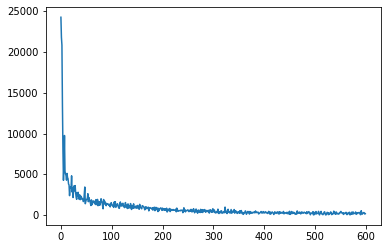

In [ ]:
# testing regressor
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images,_,box in test_loader:
      images ,box= images.to(device), box.to(device)
      _,outputs = model(images)
      outputs = outputs.reshape(outputs.size(0),-1)
      print(outputs[0],box[0])

plt.plot(loss_lis2)
plt.show()

In [ ]:
# for large images
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root_img, root_label, transforms=None):
        self.root_img = root_img
        self.root_label = root_label
        # the list of filename
        self.transforms = transforms
        self.file = open(root_label)
        self.reader = csv.reader(self.file)
        temp_lis1 = list(self.reader)
        self.lis = temp_lis1[1:]
        # the list of label

    def __getitem__(self, index):
        # obtain filenames from list
        image_filename = self.lis[index][0]
        # Load data and label
        image = Image.open(os.path.join(self.root_img, image_filename),'r')
        # print(type(image))
        width,height,cls,xmin,ymin,xmax,ymax = self.lis[index][1:]
        cls = 1

        temp_var1 ,temp_var2 = image.size
        im1 = image.resize((512, 512))
        mulx = 512/temp_var1
        muly = 512/temp_var2

        box = [[round(int(xmin)*mulx),round(int(ymin)*muly), round(int(xmax)*mulx), round(int(ymax)*muly)]]
        box = torch.tensor(box).squeeze()

        # number of objects in the image

        # Bounding boxes for objects
        cls = torch.tensor(int(cls), dtype=torch.int64)
        
        if self.transforms is not None:
            image = self.transforms(im1)
        return image,cls,box

    def __len__(self):
        return len(self.lis)

In [ ]:
valid_data_dir = '/content/raccoon_dataset/images'
valid_label = '/content/raccoon_dataset/data/test_labels.csv'
batchsize = 1

# create own Dataset
valid_dataset = myOwnDataset(root_img = valid_data_dir,root_label = valid_label,
                          transforms = get_transform()
                          )

def collate_fn(batch):
  data = [item[0] for item in batch]
  target = [item[1] for item in batch]
  box = [item[2] for item in batch]
  target = torch.LongTensor(target)
  box = torch.stack(box,dim=0)
  data = torch.stack(data,dim=0)
  return [data, target,box]
# own DataLoader

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batchsize,
                                          shuffle=True,
                                           collate_fn = collate_fn)

In [ ]:
def pyramid(image,scale,miniSize = (256,256)):
  yield image

  while True:
    w = int(image.shape[1]/scale)
    image = imutils.resize(image,width = w)

    if image.shape[0] < miniSize[1] or image.shape[1] < miniSize[0]:
      break
    
    yield image

def sliding_window(image,stepSize,windowSize):
  t_img = image.transpose((2,0,1))
  test_img = np.expand_dims(t_img, axis=0)
  test_img = torch.tensor(test_img)
  return mod(test_img)
  # yield (x,y,image[y:y+ windowSize[1],x:x + windowSize[0]])

def mod(ig):
  model.eval()
  with torch.no_grad():
    ig = ig.to(device)
    outputs,bux = model(ig)
    print('result',outputs.size())
    probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    bux = bux.cpu()
    bux = bux.numpy()
    result = probabilities.cpu()
    result = result.numpy()
    print(np.shape(result),np.shape(bux[0]))
    return result,bux[0]
    


Feature batch shape: torch.Size([1, 3, 512, 512])
box tensor([  7,  11, 505, 504])
torch.Size([1, 3, 512, 512])
tensor([1])


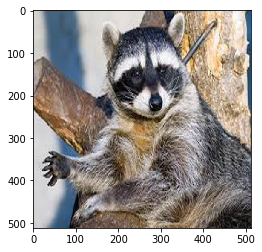

In [ ]:
valid_features, valid_labels,bbox= next(iter(valid_loader))
print(f"Feature batch shape: {valid_features.size()}")
print('box',bbox[0])
# print(f"Labels batch shape: {len(train_labels)}")
img = valid_features[0].squeeze()
img2 = valid_features
print(img2.size())
img1 = valid_features
# img1 = torchvision.transforms.functional.convert_image_dtype(image= img2,dtype=torch.uint8)
img1 = img1.numpy()
img = torchvision.transforms.functional.convert_image_dtype(image= img,dtype=torch.uint8)
img = img.numpy()
im2display = img.transpose((1,2,0))
plt.imshow(im2display, interpolation='nearest')
print(valid_labels)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 512, 512)
(512, 512, 3)
tensor([[  7,  11, 505, 504]])
result torch.Size([1, 2, 17, 17])
(2, 17, 17) (4, 17, 17)
result torch.Size([1, 2, 11, 11])
(2, 11, 11) (4, 11, 11)
result torch.Size([1, 2, 7, 7])
(2, 7, 7) (4, 7, 7)
result torch.Size([1, 2, 3, 3])
(2, 3, 3) (4, 3, 3)


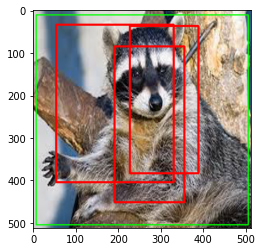

In [ ]:
print(np.shape(img1))
image = img1[0].transpose((1,2,0))
print(np.shape(image))
print(bbox)
winH = 256
winW = 256
cord_lis = []

    
font = cv2.FONT_HERSHEY_SIMPLEX
imgs = image.copy()
m = 1
for resized in pyramid(image, scale=1.2):
  blocks,cords = sliding_window(resized,1,(256,256))
  lengt = np.shape(blocks)[1]
  for y in range(lengt):
    for x in range(lengt):
      if blocks[1][x][y]>0.999976 and m>1.5 :
        tx =8*x*m
        ty = 8*y*m
        cord_lis.append((round(cords[0][x][y]*m + tx),round(cords[1][x][y]*m+ ty),round(cords[2][x][y]*m + tx),round(cords[3][x][y]*m+ ty)))
        # cv2.rectangle(imgs, (8*x, 8*y), (8*x + winW, 8*y + winH), (255, 0, 0), 2)
        # cv2.putText(imgs, "Raccoon", (8*x,8*y), font, 1, (255,0,0), 3, cv2.LINE_AA)
  m = m*1.2
# storing coordinates into list and plotting them at end
      
cv2.rectangle(imgs, (bbox[0][0], bbox[0][1]), (bbox[0][2], bbox[0][3]), (0, 255, 0), 2)
for item in cord_lis:
  cv2.rectangle(imgs, (item[0], item[1]), (item[2], item[3]), (255, 0, 0), 3)
plt.imshow(imgs)
plt.show()


    # t_img = image[y:y+winH,x:x+winW]
    # # t_img = t_img.transpose((2,0,1))
    # # print("test",np.shape(t_img))
    # test_img = np.expand_dims(t_img, axis=0)
    # # print("test",np.shape(test_img))
    # test_img = torch.tensor(test_img)
    # tet = Image.fromarray(t_img,'RGB')
    # result = foo(tet)
    # result = result.cpu()
    # result = result.numpy()
    # # with open("imagenet_classes.txt", "r") as f:
    # #     categories = [s.strip() for s in f.readlines()]
    # # Show top categories per image
    # font = cv2.FONT_HERSHEY_SIMPLEX
    # txt = cls_lis[np.argmax(result)]
    # cv2.rectangle(clone, (x, y), (x + winW, y + winH), (255, 0, 0), 2)
    # cv2.rectangle(clone, (bbox[0][0], bbox[0][1]), (bbox[0][2], bbox[0][3]), (0, 255, 0), 2)
    # cv2.putText(clone, txt, (x,y), font, 1, (255,0,0), 3, cv2.LINE_AA)
    # plt.imshow(clone)
    # plt.show()
    # plt.clf()